# Lecture 3

Day 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
import numpy as np
import scipy.integrate as spi
import scipy.stats as stats
import emcee
import astroML

Frequentist

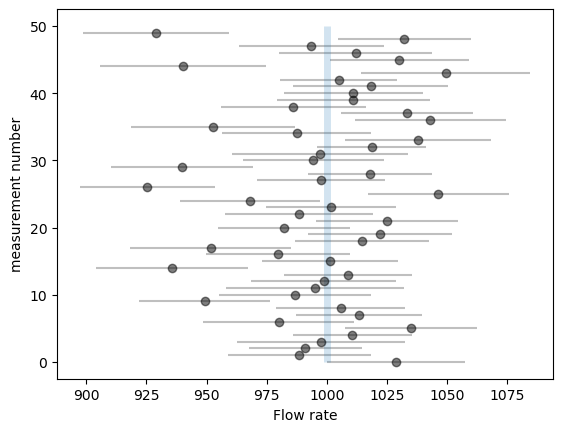

In [2]:
np.random.seed(2) # for reproducibility  
e = np.random.normal(30, 3, 50) 
F = np.random.normal(1000, e) # mean = 1000, std = error of device
 
%matplotlib inline 
import matplotlib.pyplot as plt 
 
fig, ax = plt.subplots() 
ax.errorbar(F, np.arange(50), xerr=e, fmt='ok', ecolor='gray', alpha=0.5) 
ax.vlines([1000], 0, 50, linewidth=5, alpha=0.2) 
ax.set_xlabel("Flow rate");ax.set_ylabel("measurement number"); 
plt.show()


In [3]:
w = 1. / e ** 2 
F_hat = np.sum(w * F) / np.sum(w) 
sigma_F = w.sum() ** -0.5 
print(F_hat,sigma_F)

998.6496963757094 4.113743971231106


Bayesian

In [4]:
def log_prior(theta): 
    return 1  # flat prior 
 
def log_likelihood(theta, F, e): 
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2) 
                         + (F - theta[0]) ** 2 / e ** 2) 
 
def log_posterior(theta, F, e): 
    return log_prior(theta) + log_likelihood(theta, F, e) 

In [5]:
# np.random.seed(2) # for reproducibility  
ndim = 1  # number of parameters in the model 
nwalkers = 50  # number of MCMC walkers 
nburn = 1000  # "burn-in" period to let chains stabilize 
nsteps = 2000  # number of MCMC steps to take 
 
# we'll start at random locations between 0 and 2000 
starting_guesses = 2000 * np.random.rand(nwalkers, ndim) 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e]) 
sampler.run_mcmc(starting_guesses, nsteps) 
 
sample = sampler.chain  # shape = (nwalkers, nsteps, ndim) 
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

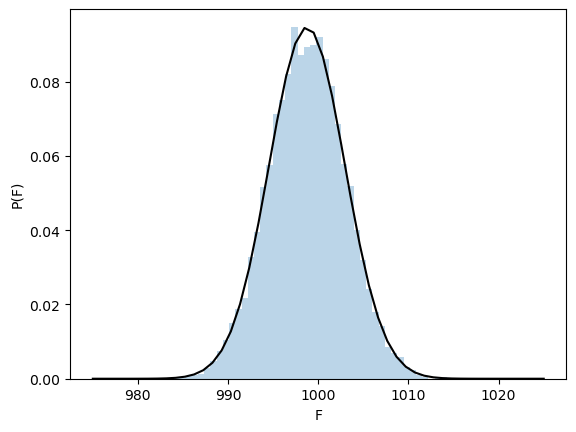

In [6]:
# plot a histogram of the sample 
from scipy import stats 
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, density=True) 
 
# plot a best-fit Gaussian 
F_fit = np.linspace(975, 1025) 
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit) 
 
plt.plot(F_fit, pdf, '-k') 
plt.xlabel("F"); plt.ylabel("P(F)")
plt.show()

In [7]:
print(sample)

[ 998.76583626  998.60206312  998.05661687 ... 1002.96548681 1002.96548681
 1004.30426812]


In [8]:
print(""" 
      F_true = {0} 
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements) 
      """.format(1000, np.mean(sample), np.std(sample), 50))

 
      F_true = 1000 
      F_est  = 999 +/- 4 (based on 50 measurements) 
      


Day 2

In [9]:
np.random.seed(42)  # for reproducibility 
N = 100  # we'll use more samples for the more complicated model 
mu_true, sigma_true = 1000, 15  # stochastic flow rate model 
F_true = stats.norm(mu_true, sigma_true).rvs(N)  # (unknown) true flow rate 
F = stats.poisson(F_true).rvs()  # observed flow rate: true flow rate plus Poisson errors. # additive noise
e = np.sqrt(F)  # root-N error, as above 

In [10]:
def log_likelihood(theta, F, e): 
    return -0.5 * np.sum(np.log(2 * np.pi * (theta[1] ** 2 + e ** 2)) 
                         + (F - theta[0]) ** 2 / (theta[1] ** 2 + e ** 2)) 
 
# maximize likelihood <--> minimize negative likelihood 
def neg_log_likelihood(theta, F, e): 
    return -log_likelihood(theta, F, e) 
 
from scipy import optimize 
theta_guess = [900, 5] 
theta_est = optimize.fmin(neg_log_likelihood, theta_guess, args=(F, e)) 
print(""" 
      Maximum likelihood estimate for {0} data points: 
          mu={theta[0]:.0f}, sigma={theta[1]:.0f} 
      """.format(N, theta=theta_est))

Optimization terminated successfully.
         Current function value: 502.839505
         Iterations: 58
         Function evaluations: 114
 
      Maximum likelihood estimate for 100 data points: 
          mu=999, sigma=19 
      


In [11]:
from astroML.resample import bootstrap 
 
def fit_samples(sample): 
    # sample is an array of size [n_bootstraps, n_samples] 
    # compute the maximum likelihood for each bootstrap. 
    return np.array([optimize.fmin(neg_log_likelihood, theta_guess, 
                                   args=(F, np.sqrt(F)), disp=0) 
                     for F in sample]) 
 
samples = bootstrap(F, 1000, fit_samples)  # 1000 bootstrap resamplings
mu_samp = samples[:, 0] 
sig_samp = abs(samples[:, 1]) 
 
print (" mu    = {0:.0f} +/- {1:.0f}".format(mu_samp.mean(), 
mu_samp.std())) 
print (" sigma = {0:.0f} +/- {1:.0f}".format(sig_samp.mean(), 
sig_samp.std()))

 mu    = 999 +/- 4
 sigma = 18 +/- 5


Bayesian

/home/brando/miniconda3/envs/MSTA/lib/python3.14/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


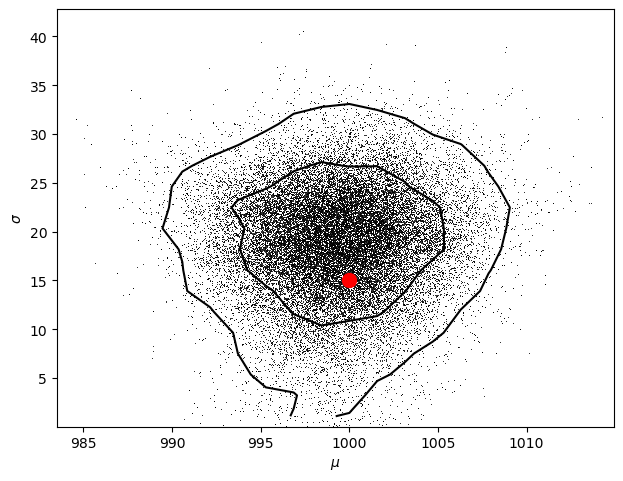

In [12]:
def log_prior(theta): 
    # sigma needs to be positive. 
    if theta[1] <= 0: 
        return -np.inf 
    else: 
        return 0 
 
def log_posterior(theta, F, e): 
    return log_prior(theta) + log_likelihood(theta, F, e) 
 
# same setup as above: 
ndim, nwalkers = 2, 50 
nsteps, nburn = 2000, 1000 
 
starting_guesses = np.random.rand(nwalkers, ndim) 
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000 
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20 
 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, 
e]) 
sampler.run_mcmc(starting_guesses, nsteps) 
 
sample = sampler.chain  # shape = (nwalkers, nsteps, ndim) 
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

from astroML.plotting import plot_mcmc 
fig = plt.figure() 
ax = plot_mcmc(sample.T, fig=fig, labels=[r'$\mu$', r'$\sigma$'], 
colors='k') 
ax[0].plot(sample[:, 0], sample[:, 1], ',k', alpha=0.8)

ax[0].plot([mu_true], [sigma_true], 'o', color='red', ms=10); 
# plt.savefig('/content/drive/MyDrive/PSU/ColabNotebooks/Example3_3.png', 
# dpi=300)
plt.show()

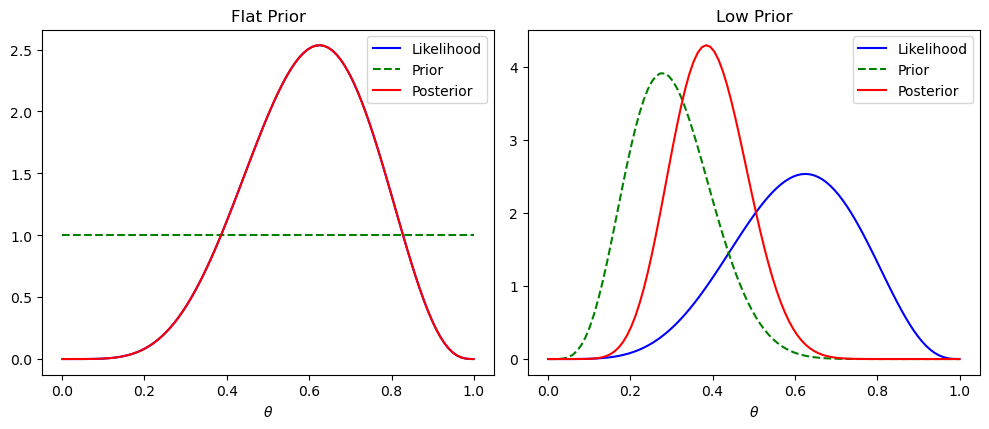

In [13]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import beta 
 
n, k = 8, 5 
 
# Create a figure for the plots 
fig = plt.figure(figsize=(10, 8)) 
 
# Plot 1: Flat prior 
a, b = 1, 1 
ax = fig.add_subplot(221) 
theta = np.linspace(1e-3, 1 - 1e-3, 100) 
 
# Likelihood, prior, and posterior plots 
ax.plot(theta, beta.pdf(theta, k + 1, n - k + 1), label='Likelihood', 
color='blue') 
ax.plot(theta, beta.pdf(theta, a, b), ls='--', label='Prior', 
color='green') 
ax.plot(theta, beta.pdf(theta, k + a, n - k + b), label='Posterior', 
color='red') 
 
# Set axis label 
ax.set_xlabel(r'$\theta$') 
 
# Add a legend for the plots 
ax.legend() 
 
# Set the title for the subplot 
ax.set_title('Flat Prior') 
 
# Plot 2: Low prior 
a, b = 6, 14 
ax = fig.add_subplot(222) 
 
# Likelihood, prior, and posterior plots 
ax.plot(theta, beta.pdf(theta, k + 1, n - k + 1), label='Likelihood', 
color='blue') 
ax.plot(theta, beta.pdf(theta, a, b), ls='--', label='Prior', 
color='green') 
ax.plot(theta, beta.pdf(theta, k + a, n - k + b), label='Posterior', 
color='red') 
 
# Set axis label 
ax.set_xlabel(r'$\theta$') 

 
# Add a legend for the plots 
ax.legend() 
 
# Set the title for the subplot 
ax.set_title('Low Prior') 
 
# Show the figure 
plt.tight_layout() 
plt.show()

In [14]:
# informative prior
c = a + b
theta_mean = (k+a)/(n+c)
theta_map = (k+a-1)/(n+c-2)

print(theta_mean)
print(theta_map)
# uninformative prior
theta_mle_mean = (k+1)/(n+2)
theta_mle_map = (k)/(n) # this is mle (just frequentist)

print(theta_mle_mean)
print(theta_mle_map)

0.39285714285714285
0.38461538461538464
0.6
0.625


In [15]:
lmd = c/(n+c)
posterior_mean = (lmd*(a/c)) + ((1-lmd)*theta_mle_mean)
print(posterior_mean) # expected value of the posterior
var_mean = ((a+k)*(b+n-k))/(((a+k+b+n-k)**2)*(a+k+b+n-k+1))
print(var_mean) # variance of the posterior

0.3857142857142857
0.008224841660802252


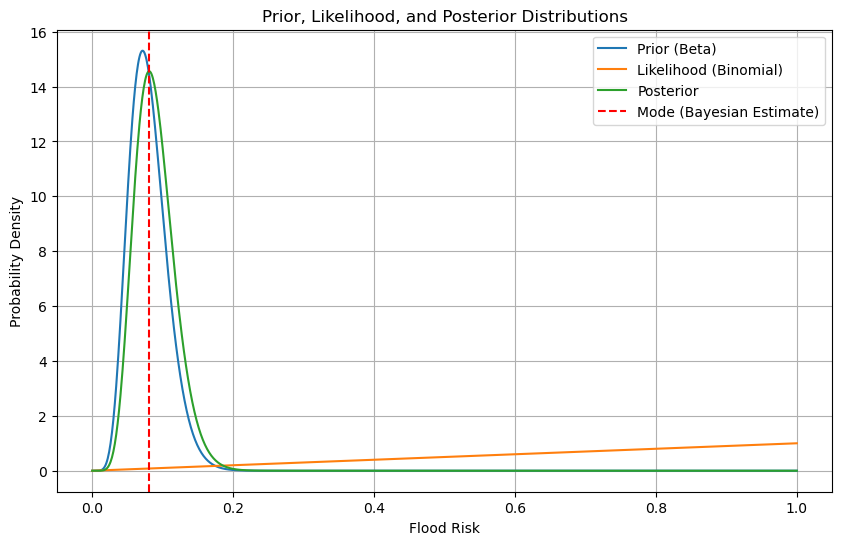

Bayesian estimate of flood risk (mode of posterior): 8.10%


In [17]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import beta, binom 
 
# Define the prior parameters (Beta distribution) 
alpha_prior = 8 
beta_prior = 92 
# Define the likelihood parameters (Binomial distribution) 
n_observed = 1  # One observed flood event exceeding the threshold 
p_values = np.linspace(0, 1, 1001)  # A range of possible flood risk values 
 
# Calculate the prior, likelihood, and posterior 
prior = beta.pdf(p_values, alpha_prior, beta_prior) 
likelihood = binom.pmf(n_observed, 1, p_values)  # Probability of observing 1 flood event given p 
posterior = prior * likelihood 
 
# Normalize the posterior to make it a valid probability distribution 
posterior /= np.trapezoid(posterior, p_values) 
 
# Calculate the mode of the posterior (Bayesian estimate) 
mode_posterior = p_values[np.argmax(posterior)] 
 
# Plot the prior, likelihood, and posterior distributions 
plt.figure(figsize=(10, 6)) 
plt.plot(p_values, prior, label='Prior (Beta)') 
plt.plot(p_values, likelihood, label='Likelihood (Binomial)') 
plt.plot(p_values, posterior, label='Posterior') 
plt.axvline(mode_posterior, color='red', linestyle='--', label='Mode (Bayesian Estimate)') 
plt.xlabel('Flood Risk') 
plt.ylabel('Probability Density') 
plt.legend() 
plt.title('Prior, Likelihood, and Posterior Distributions') 
plt.grid() 
plt.show() 
 
print(f'Bayesian estimate of flood risk (mode of posterior): {mode_posterior:.2%}')

[spacer]

# CE410/510: Modern Statistics for Engineers, Homework 3

Completed by Brandon Auyeung for Dr. Peyman Abbaszadeh 

Due Date: 2nd of February, 2026


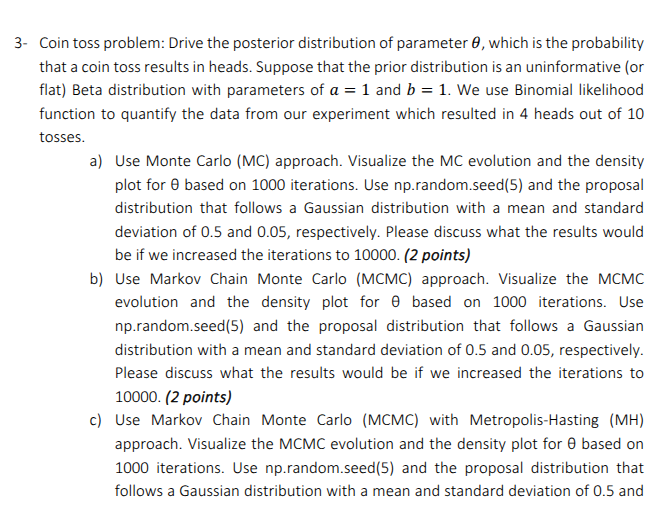

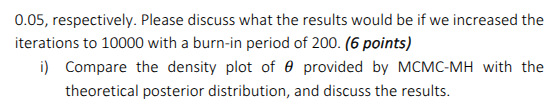

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
import numpy as np
import scipy.integrate as spi
import scipy.stats as stats
import emcee
import astroML
from scipy import optimize as opt
from scipy import integrate 

## Problem 1. 

### Part a

$$ \mathcal{L} =  \mathbb{P}(x | \lambda) = \frac{1}{Z(\lambda)} \left[\frac{1}{\lambda}\right] e^{-\frac{x}{\lambda}} \ \text{if} \  x \in [1,20] $$

where:

$$  Z(\lambda) = \int_1^{20} \frac{1}{\lambda}e^{-\frac{x}{\lambda}} dx = e^{-\frac{1}{\lambda}} - e^{-\frac{20}{\lambda}}$$

Visualize $ \mathbb{P}(x|\lambda) \ \text{for} \  \lambda = 2, 5, 10 $

In [68]:
lmbds = np.array([2,5,10]) # define lambda values for visualization

def Z_func(lamb): # define Z function 
    return np.exp(-1/lamb) - np.exp(-20/lamb)

def likelihood(x, lamb, x_axis, lamb_axis): # define likelihood
    
    if len(x_axis) > len(lamb_axis): # use the longer array
        L = np.zeros(len(x_axis))
        for index, value in enumerate(x):
            if value < 1 or value > 20: # guard clause: x must be between 1 and 20
                print('x must be between 1 and 20')
                return
            else:
                L[index] = (1/(Z_func(lamb))) * (1/lamb) * np.exp(-value/lamb)
    else:
        L = np.zeros(len(lamb_axis))
        for index, value in enumerate(lamb):
                L[index] = (1/(Z_func(value))) * (1/value) * np.exp(-x/value)
    return L

(0.0, 0.5)

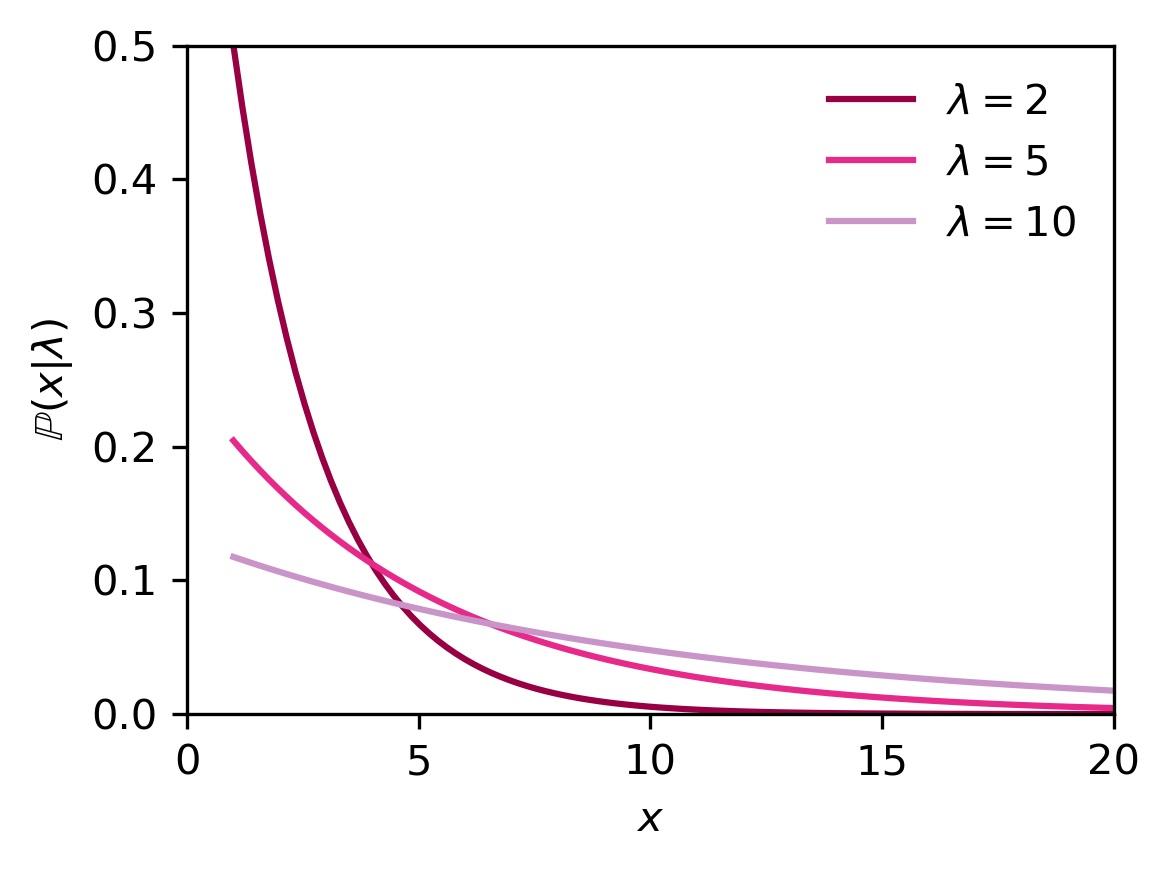

In [77]:
x_axis = np.linspace(1, 20, 100) # define x values for visualization
colors = ['#980043', '#e7298a', '#c994c7']

fig, ax = subplots(figsize=(4, 3), dpi=300, tight_layout=True)

for index, lamb in enumerate(lmbds):
    ax.plot(x_axis, likelihood(x_axis, lamb, x_axis, lmbds), label=f'$\\lambda = {lamb}$', color=colors[index]) # plot likelihood for each lambda value
plt.xlabel('$x$')
plt.ylabel('$\\mathbb{P}(x|\\lambda)$')
plt.legend(frameon = False, loc = 'best')
plt.xlim(0, 20)
plt.ylim(0, 0.5)


### Part b

Visualize $ \mathbb{P}(x|\lambda) \ \text{for} \  x = 2, 5, 10 $

/tmp/ipykernel_15848/1826457997.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-1/lamb) - np.exp(-20/lamb)
/tmp/ipykernel_15848/1826457997.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  L[index] = (1/(Z_func(value))) * (1/value) * np.exp(-x/value)
/tmp/ipykernel_15848/1826457997.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  L[index] = (1/(Z_func(value))) * (1/value) * np.exp(-x/value)


(0.0, 0.5)

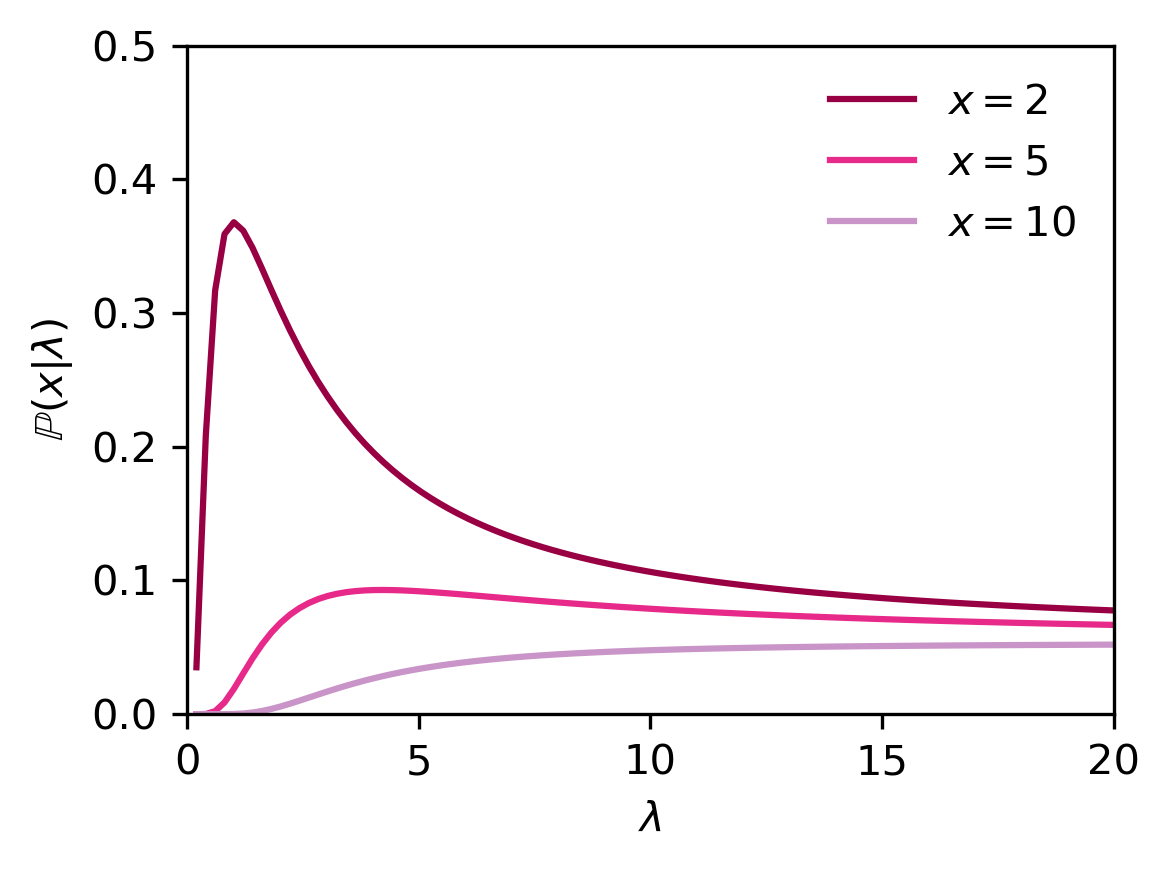

In [76]:
lamb_axis = np.linspace(0, 20, 100) # define lambda values for visualization
x = np.array([2,5,10])
fig, ax = subplots(figsize=(4, 3), dpi=300, tight_layout=True)

for index, value in enumerate(x):
    ax.plot(lamb_axis, likelihood(value, lamb_axis, x, lamb_axis), label=f'$x = {value}$', color=colors[index]) # plot likelihood for each lambda value
plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathbb{P}(x|\\lambda)$')
plt.legend(frameon = False, loc = 'best')
plt.xlim(0, 20)
plt.ylim(0, 0.5)

Assume $ D = \{3,7,2,12,5\}$ and assume the posterior is shaped as follows.

$$  \mathbb{P}(\lambda | D) = \frac{\mathbb{P}(D|\lambda)\mathbb{P}(\lambda)}{\mathbb{P}(D)} \propto \frac{1}{[\lambda(Z(\lambda))]^N} \ \text{exp}\left(  -\sum_i^n \frac{x_i}{\lambda} \right)  \mathbb{P}(\lambda)    $$

Visualize $ \mathbb{P}(\lambda | D) $ under two situations.
1. an uninformative (i.e. flat) prior
2. a Gaussian prior of form $\mathbb{P}(\lambda) = \mathcal{N}(10,5^2)$